In [4]:
import numpy as np
import pandas as pd
from dobbel import dobbellogger

In [2]:
dob = dobbellogger()
dob.log(10, 200, 8, 125)
dob.download()
data = dob.datadf

Logging data for 10s
Done! The data is located in self.datadf


In [5]:
def expq(vector, multiplier=1):
    x, y, z = vector[0] * multiplier, vector[1] * multiplier, vector[2]  * multiplier
    absq = (x ** 2 + y ** 2 + z ** 2) ** 1/2
    w = np.cos(absq)
    sinabs = np.sin(absq)
    xq = x * sinabs / absq
    yq = y * sinabs / absq
    zq = z * sinabs / absq
    return np.array([w, xq, yq, zq])

In [4]:
def quat_mul(p, q):
    p0 = p[0]
    q0 = q[0]
    pv = p[1:]
    qv = q[1:]
    out0 = p0 * q0 - np.dot(pv, qv)
    outv = p0 * qv + q0 * pv + np.cross(pv, qv)
    out = np.array([out0, *outv])
    return out

In [5]:
def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

In [6]:
# Actual Rotation Fuction - Input = Acceleration vector = 1x3 , rotation_quaternion = 1*4
def rotate_vector(vector, rotation_quaternion):
    # Convert the vector to a quaternion
    vector_quaternion = np.concatenate(([0], vector))

    # Calculate the rotated quaternion
    rotated_quaternion = quat_mul(rotation_quaternion, quat_mul(vector_quaternion, quaternion_conjugate(rotation_quaternion)))

    # Extract the rotated vector from the quaternion
    rotated_vector = rotated_quaternion[1:]

    return np.array(rotated_vector)

In [7]:
def remove_nan(df):
    counter = 0
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter += 1
    for i in range(counter - 1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    counter = len(df) - 1
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter -= 1
    maxlen = len(df)
    for i in range(maxlen - 1, counter + 1, -1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        df['timestamp'][i] = df['timestamp'][i] - df['timestamp'][0]
    for i in range(len(df)):
        for column in df.columns:
            if np.isnan(df[column][i]):
                deler = (df['timestamp'][i] - df['timestamp'][i - 1]) / (df['timestamp'][i + 1] - df['timestamp'][i - 1])
                df[column][i] = df[column][i - 1] + deler * (df[column][i + 1] - df[column][i - 1])
    return df

In [8]:
data = remove_nan(data)
data.head(1000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.600098,-0.015625,0.782715,-0.342988,-0.053354,-0.449695
1,25.0,0.600830,-0.013672,0.782227,-0.078337,0.624153,-0.679059
2,27.0,0.601318,-0.012695,0.782878,-0.057165,0.678354,-0.697409
3,31.0,0.602295,-0.010742,0.784180,0.026677,0.476372,0.201982
4,35.0,0.603271,-0.017822,0.785645,-0.026677,0.434451,0.019055
...,...,...,...,...,...,...,...
995,4822.0,0.692139,0.037109,0.693115,-1.920732,1.349085,-2.663872
996,4828.0,0.685791,0.051025,0.710449,0.861281,1.432927,0.403963
997,4833.0,0.666504,0.022217,0.732666,-6.653964,-0.415396,-8.647104
998,4837.0,0.699463,-0.013672,0.704590,-4.622714,-0.384909,-8.163110


In [9]:
def detect_number(arr):
    x, y, z = arr
    print(x, y, z)
    if x < - 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 1
    elif np.abs(x) < 0.1 and y > 0.8 and np.abs(z) < 0.1:
        return 2
    elif x > 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 3
    elif x < 0.5 and np.abs(y) < 0.1 and z > -0.5:
        return 4
    elif np.abs(x) < 0.1 and y < -0.8 and np.abs(z) < 0.1:
        return 5
    elif x > 0.5 and np.abs(y) < 0.1 and z > 0.5:
        return 6
    else:
        return 'Could not detect number'

In [ ]:
def kalman_1d(state, acc, gyro, uncertainty):
    

In [10]:
gravDetectTime = 100

gyro_bias = np.array([0, 0, 0])
acc_bias = np.array([0, 0, 0])
gyro_noise = np.array([0, 0, 0])
acc_noise_p = np.array([0, 0, 0])
acc_noise_v = np.array([0, 0, 0])

q = np.array([1, 0, 0, 0])
v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [q]
p_list = [p]
v_list = [v]

Pttmin1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

Q = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

arr = np.array([data['x_acc'][:gravDetectTime], data['y_acc'][:gravDetectTime], data['z_acc'][:gravDetectTime]])
mean_grav = np.array([9.81 * sum(arr[0,:]) / len(arr[0, :]), 9.81 * sum(arr[1,:]) / len(arr[1, :]), 9.81 * sum(arr[2,:]) / len(arr[2, :])])

for i in range(gravDetectTime, len(data['timestamp']) - 1):
    dt = (data['timestamp'][i + 1] - data['timestamp'][i]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement - gyro_bias - gyro_noise
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    
    Ftmin1 = np.array([
        [expq_omega[0], -expq_omega[1], -expq_omega[2], -expq_omega[3]],
        [expq_omega[1], expq_omega[0], expq_omega[3], -expq_omega[2]],
        [expq_omega[2], -expq_omega[3], expq_omega[0], expq_omega[1]],
        [expq_omega[3], expq_omega[2], -expq_omega[1], expq_omega[0]]
    ])
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Pttmin1), Ftmin1.T) + Q
    
    q = quat_mul(q, expq_omega)
    ab = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    ab = 9.81 * ab
    an = rotate_vector(ab, q) - rotate_vector(mean_grav, q)
    anp = an - acc_bias - acc_noise_p
    anv = an - acc_bias - acc_noise_v
    p = p + dt * v + 0.5 * anp * dt ** 2
    v = v + dt * anv
    q_list.append(q)
    p_list.append(p)
    v_list.append(v)

estimate = pd.DataFrame(columns=['timestamp', 'x_p', 'y_p', 'z_p'])
estimate['timestamp'] = data['timestamp'][gravDetectTime:]

p_array = np.array(p_list)
estimate['x_p'] = p_array[:, 0]
estimate['y_p'] = p_array[:, 1]
estimate['z_p'] = p_array[:, 2]

In [11]:
estimate.head(1000)

,timestamp,x_p,y_p,z_p
100,498.0,0.000000e+00,0.000000e+00,0.000000e+00
101,504.0,8.478441e-08,1.510304e-07,2.169260e-08
102,508.0,1.013750e-07,4.195236e-07,-1.313351e-07
103,513.0,-1.491242e-07,1.093614e-06,-3.852917e-07
104,519.0,-4.164144e-07,2.229715e-06,-5.137676e-07
...,...,...,...,...
1095,5306.0,1.393954e-01,-3.001365e-01,-4.422409e-02
1096,5310.0,1.403916e-01,-3.004864e-01,-4.502463e-02
1097,5316.0,1.418751e-01,-3.010249e-01,-4.620069e-02
1098,5321.0,1.430856e-01,-3.014806e-01,-4.716365e-02


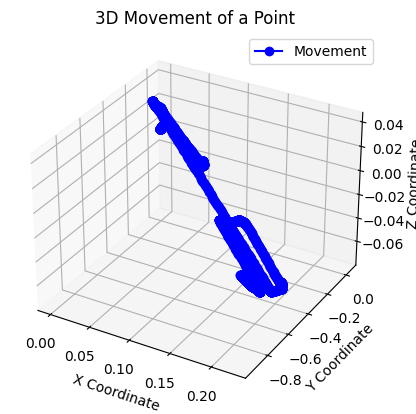

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data: Replace these with your actual lists of coordinates
x_positions = p_array[:, 0]
y_positions = p_array[:, 1]
z_positions = p_array[:, 2]

# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(x_positions, y_positions, z_positions, marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()
